# Gravitational Wave Inference Demonstration

This notebook demonstrates how to classify noisy data from the LIGO and VIRGO observatories into those segments containing gravitational wave (GW) signals and those segments that do not. Our model is a spatiotemporal-graph AI (hybrid dilated convolution neural networks and graph neural networks, see [arXiv:2306.15728](https://arxiv.org/abs/2306.15728)) that has been trained using distributed training ressources on NCSA Delta. 

In [1]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed

from utils import *

## Data preparation 

Our input data consists of gravitational wave strains h(t). h(t) represents the relative change in distance between test masses in the interferometers due to a passing GW wave as a function of time. This strain data can be analyzed to infer properties of the GW sources (e.g. colliding black holes or neutron stars).

The training segments are 1 second long, consisting of either pure noise or noise with a synthetic GW signal injected. The neural network predicts the probability of a GW at each of the 4096 time steps, with ground truth labels being 0 (no GW) or 1, during the 0.5 seconds before the merger, (GW).

###  SNR scheduling

We employ signal-to-noise ratio (SNR) scheduling in our training, progressively introducing the network to waveforms with lower SNRs as training continues.

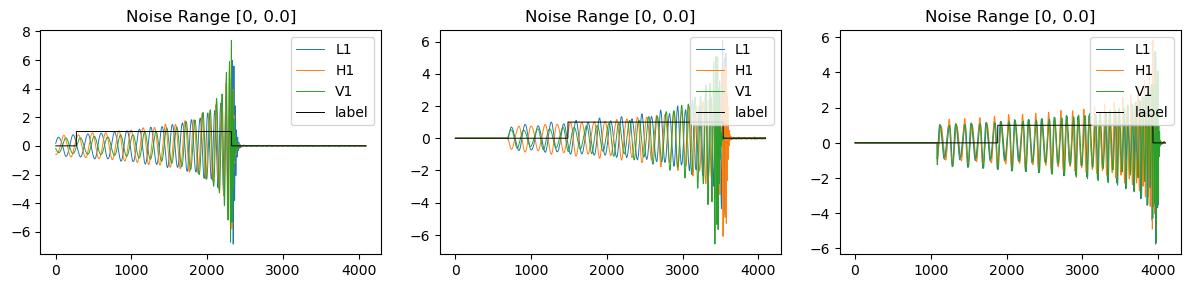

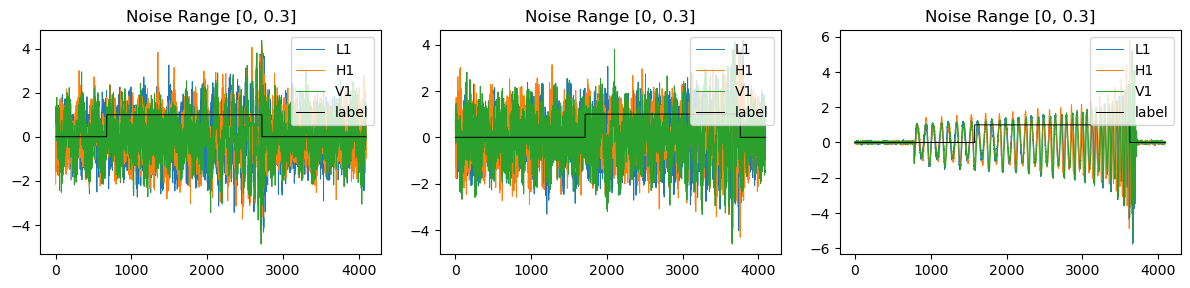

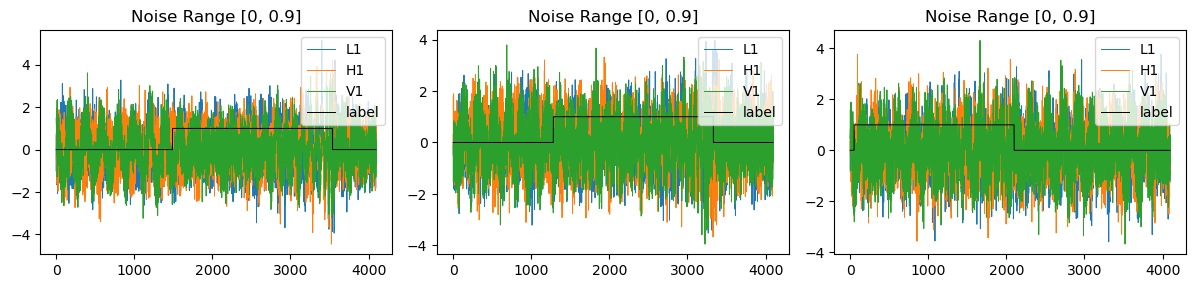

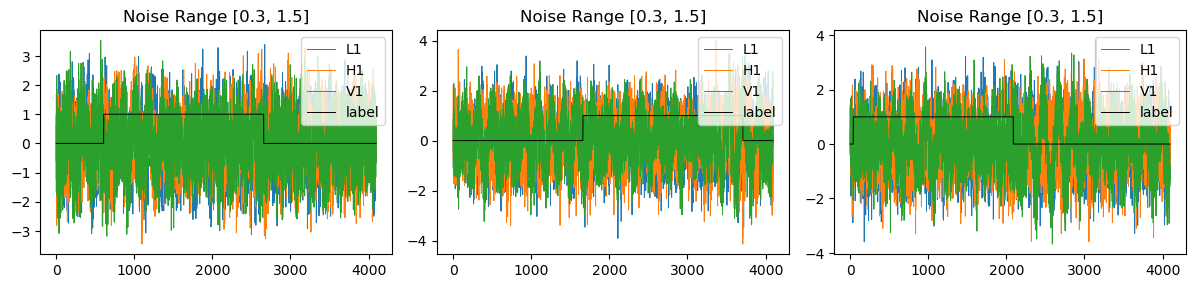

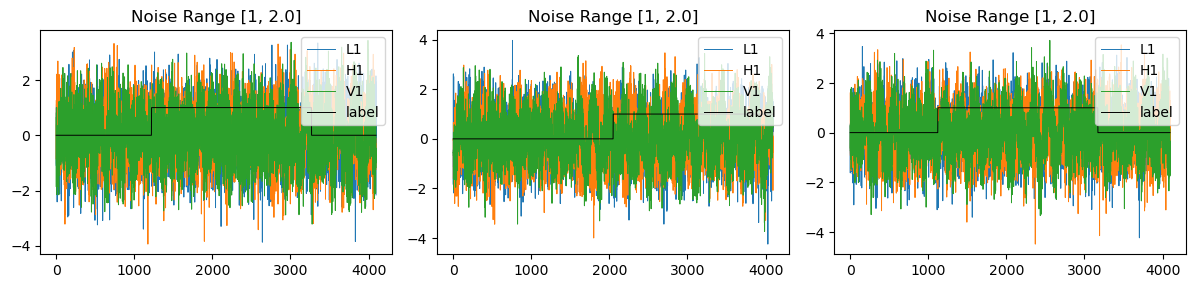

In [2]:
noise_ranges = [[0, 0.0], [0, 0.3], [0, 0.9],[0.3, 1.5], [1, 2.0]]
plot_waveforms(wf_dataset, noise_ranges)

### Whitening

Whitening is necessary since the noise characteristics of GW detectors are not uniform across all frequencie. We use the known noise power spectral density (PSD) of each detector to whiten/normalize the signals.

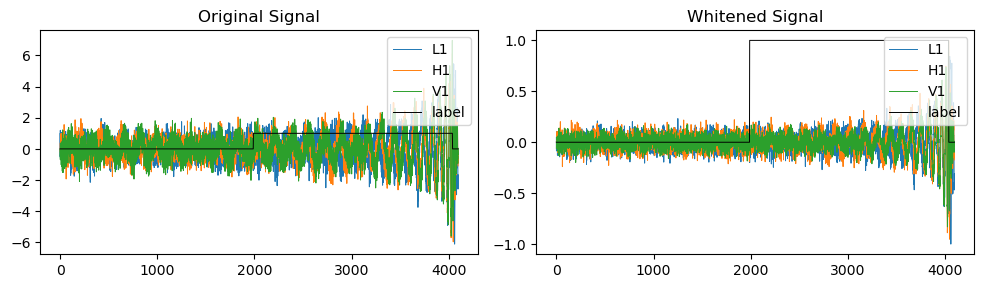

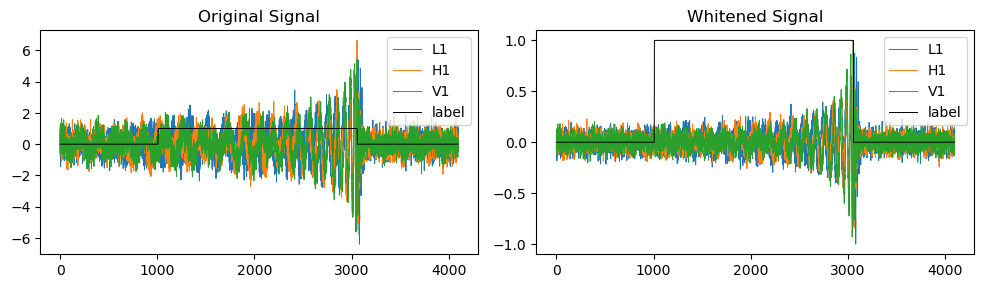

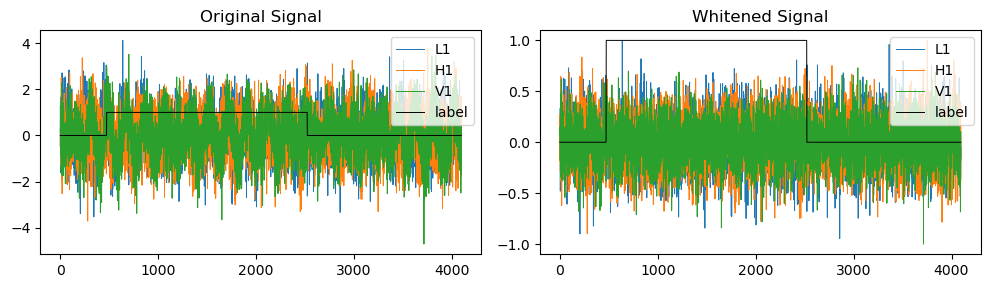

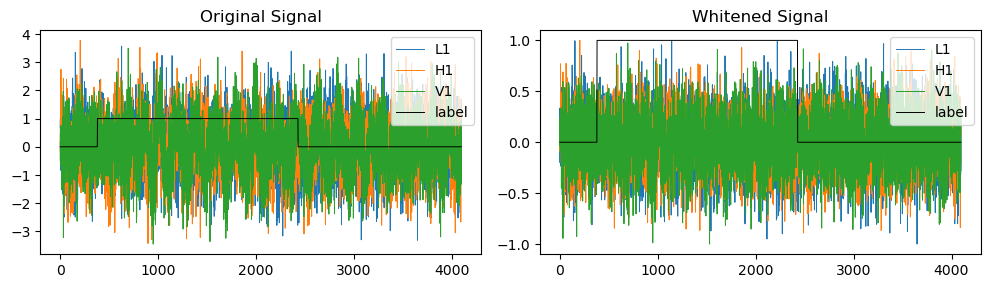

In [3]:
noise_ranges = [[0.1, 0.1], [0.1, 0.1],[1000,1000],[1000,1000]]
plot_whitened_waveforms(wf_dataset, noise_ranges)

## Inference

Our inference dataset comprises real data from the LIGO and VIRGO observatories. It consists of three separate sequences, each 4096 seconds long. The data has already been preprocessed and whitened before we load it here. A gravitational wave is present in each sequence at approximately the 1925-second mark.

### Procedure

The neural network processes these segments to predict the likelihood of gravitational wave events at each time step. Significant peaks in these predictions, which indicate a potential gravitational wave signals, are identified using specified width and height parameters. These identified peaks are then used to determine detection triggers, which are the exact time points where the gravitational waves are detected. 

### Model loading and distribution

Here, we set the inference hyperparameters. We load 4 models onto 4 gpus respectively in order to optimize prediction

In [4]:
class InferenceConfig:
    batch_size = 64
    feb_data_dir = '/scratch/bbke/victoria/WaveNet_data/Feb_Events/'
    checkpoint_dir = '/scratch/bbke/victoria/WaveNet_training/checkpoints/'
    n_channels = 3
    length = None

inference_args = InferenceConfig()

def load_model(checkpoint_name, device):
    checkpoint_path = os.path.join(inference_args.checkpoint_dir, checkpoint_name)
    state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict']
    new_state_dict = {key[len("model."):] if key.startswith("model.") else key: value for key, value in state_dict.items()} #this is because there is a slight discrepancy in names between the saved and loaded model
    model = full_module()
    model.load_state_dict(new_state_dict)
    model = model.to(device)
    return model

devices = [torch.device(f'cuda:{i}' if torch.cuda.device_count() > i else 'cpu') for i in range(4)]
#models=['2channel_epoch=20-val_loss=0.02351.ckpt','2channel_epoch=20-val_loss=0.02351.ckpt','2channel_epoch=20-val_loss=0.02351.ckpt','2channel_epoch=20-val_loss=0.02351.ckpt']
models=['2channel_epoch=20-val_loss=0.02351.ckpt', 
        '2channel_epoch=20-val_loss=0.02351.ckpt', 
        '2channel_epoch=20-val_loss=0.02351.ckpt', 
        '2channel_epoch=20-val_loss=0.02351.ckpt'] #0.02588,0.02368
model_filenames = [inference_args.checkpoint_dir+models[0],inference_args.checkpoint_dir+models[1],inference_args.checkpoint_dir+models[2],inference_args.checkpoint_dir+models[3]]
models = [load_model(filename, device) for filename, device in zip(model_filenames, devices)]
data_dirs = sorted(glob.glob(f"{inference_args.feb_data_dir}/GW*.hdf5"))

print('devices: ',devices)

devices:  [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]


### Prediction

In [5]:
data_dirs = sorted(glob.glob(f"{inference_args.feb_data_dir}/GW*.hdf5"))
dataset_name_to_dir = {data_dir.split('/')[-1].split('_')[0]: data_dir for data_dir in data_dirs}
dataset_triggers = {data_dir.split('/')[-1].split('_')[0]: [] for data_dir in data_dirs}

with ThreadPoolExecutor(max_workers=6*4) as executor:
    futures = []
    for threshold in [0.9]:
        print(f"threshold: {threshold}", flush=True)
        for width in [1000]:
            print('width: ', width, flush=True)
            for data_dir in data_dirs:
                for model in models:
                    futures.append(executor.submit(process_data, data_dir, model, threshold, width, inference_args))

    for future in as_completed(futures):
        dataset_name, triggers, _, _, _ = future.result()
        dataset_triggers[dataset_name].append(triggers)

threshold: 0.9
width:  1000


Predicting for GW200129:   0%|          | 0/61 [00:01<?, ?it/s]

Predicting for GW200224:   0%|          | 0/61 [00:00<?, ?it/s]

Predicting for GW200216:   0%|          | 0/61 [00:00<?, ?it/s]

Predicting for GW200208:   0%|          | 0/61 [00:00<?, ?it/s]

Predicting for GW200209:   0%|          | 0/61 [00:00<?, ?it/s]

Predicting for GW200219:   0%|          | 0/61 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

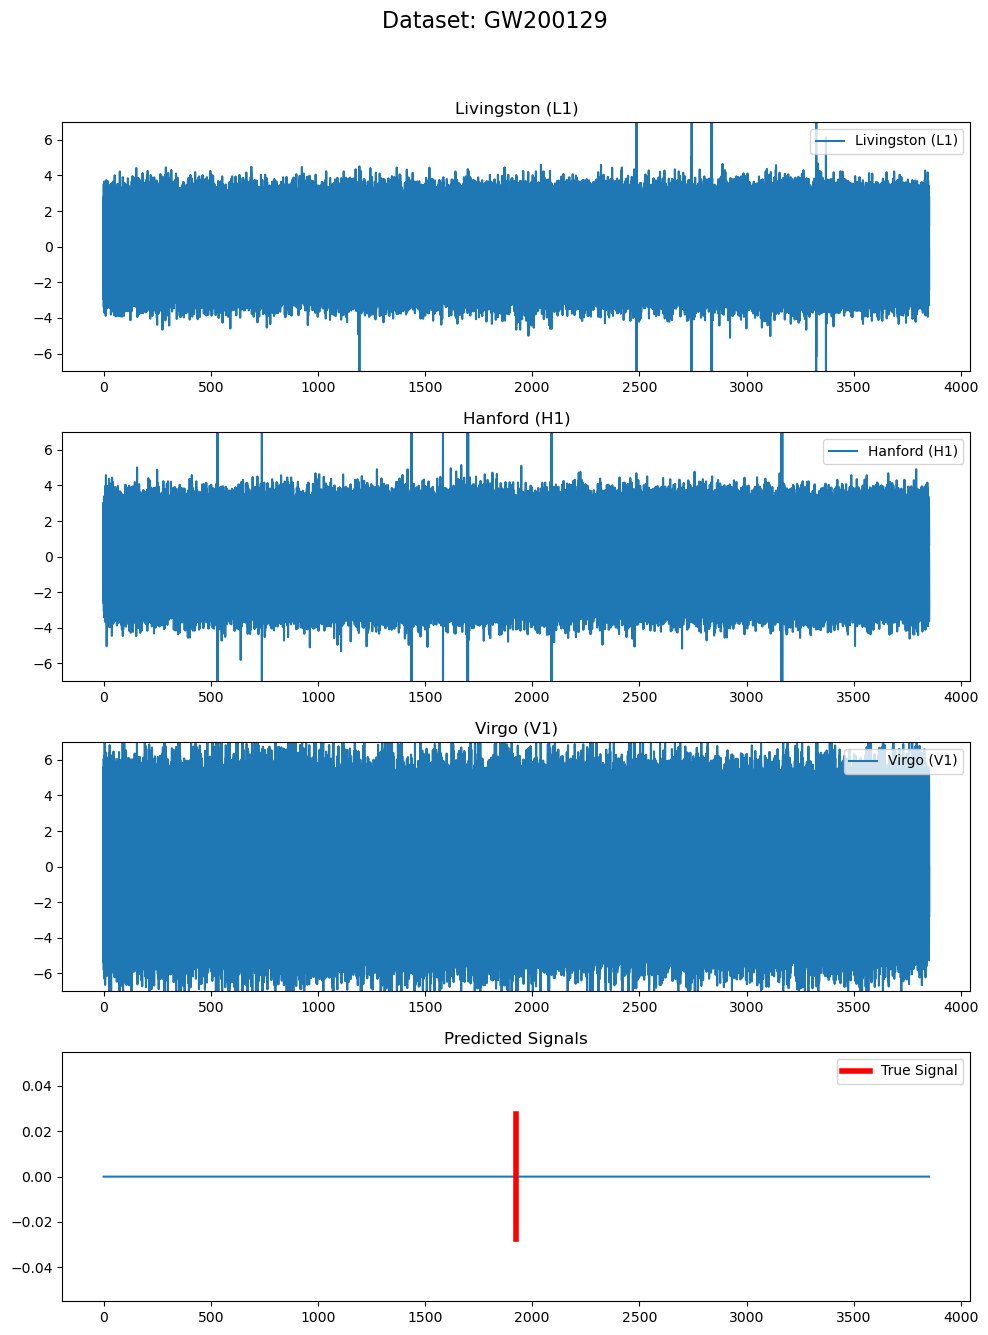

<Figure size 640x480 with 0 Axes>

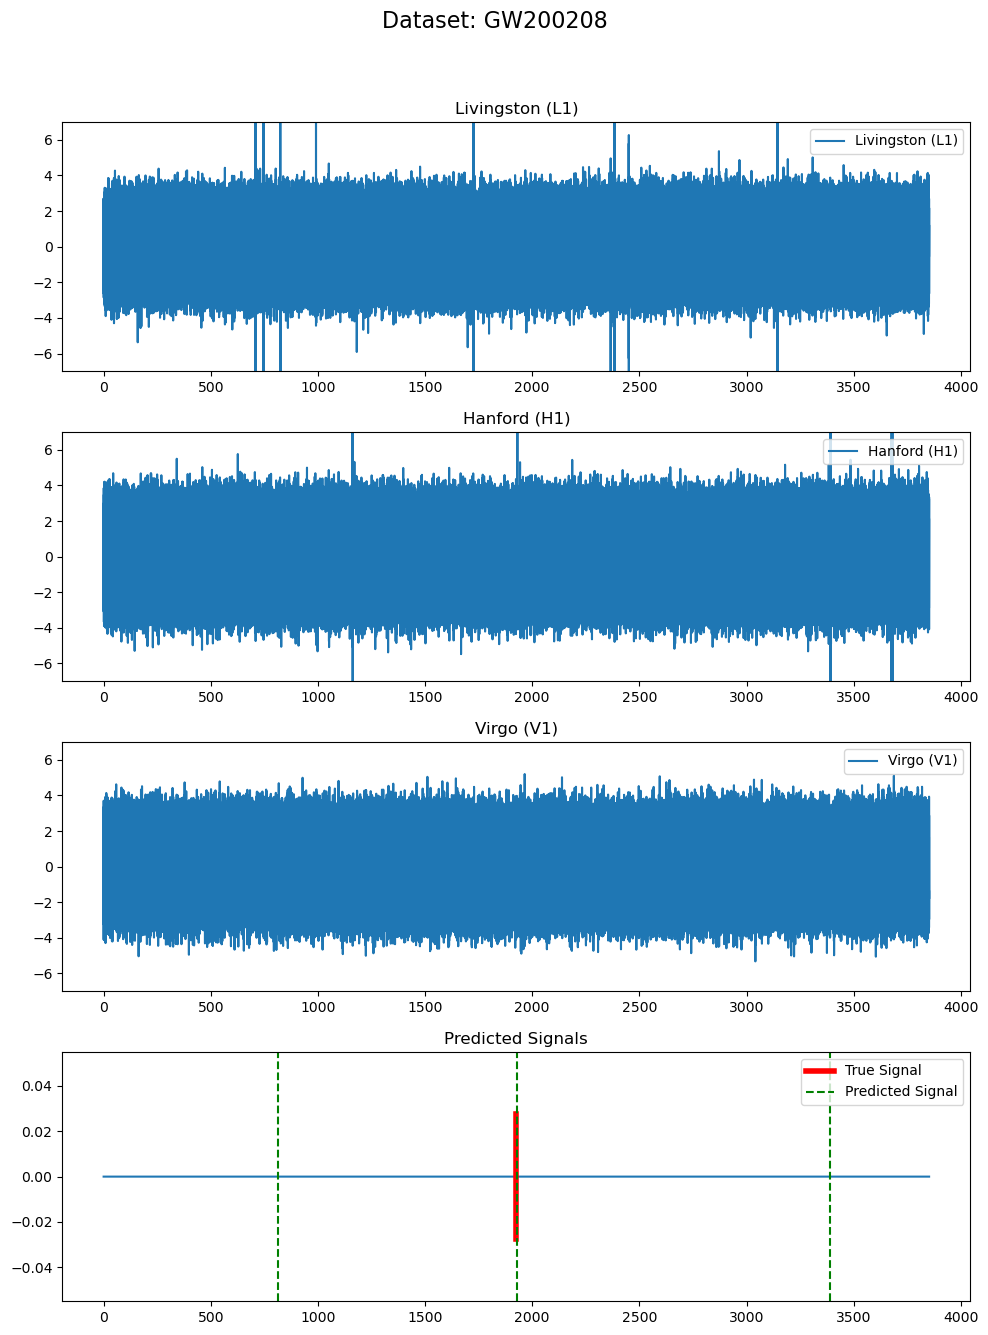

<Figure size 640x480 with 0 Axes>

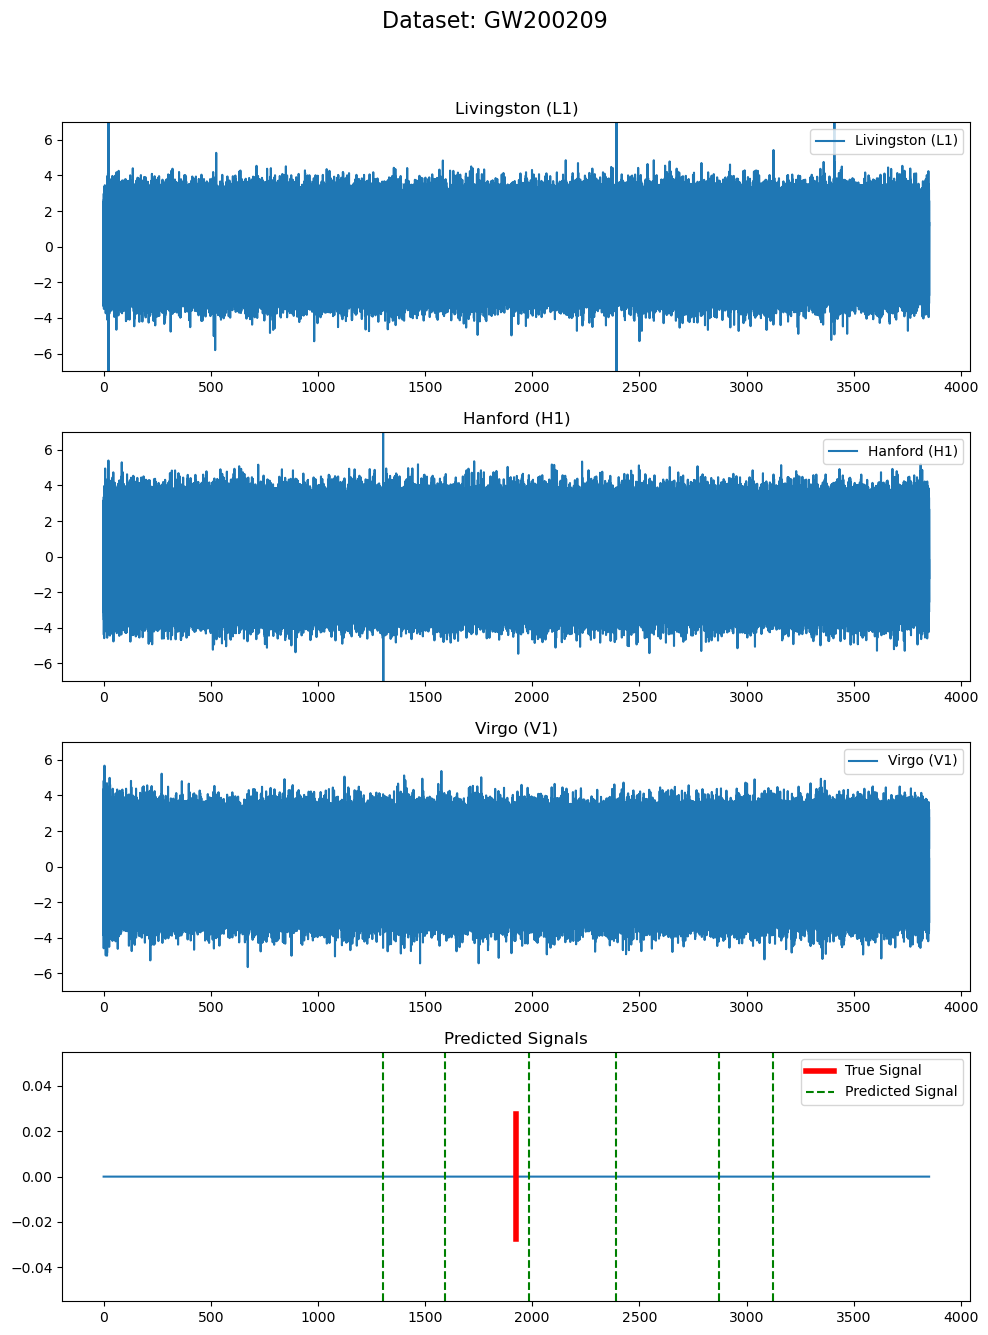

<Figure size 640x480 with 0 Axes>

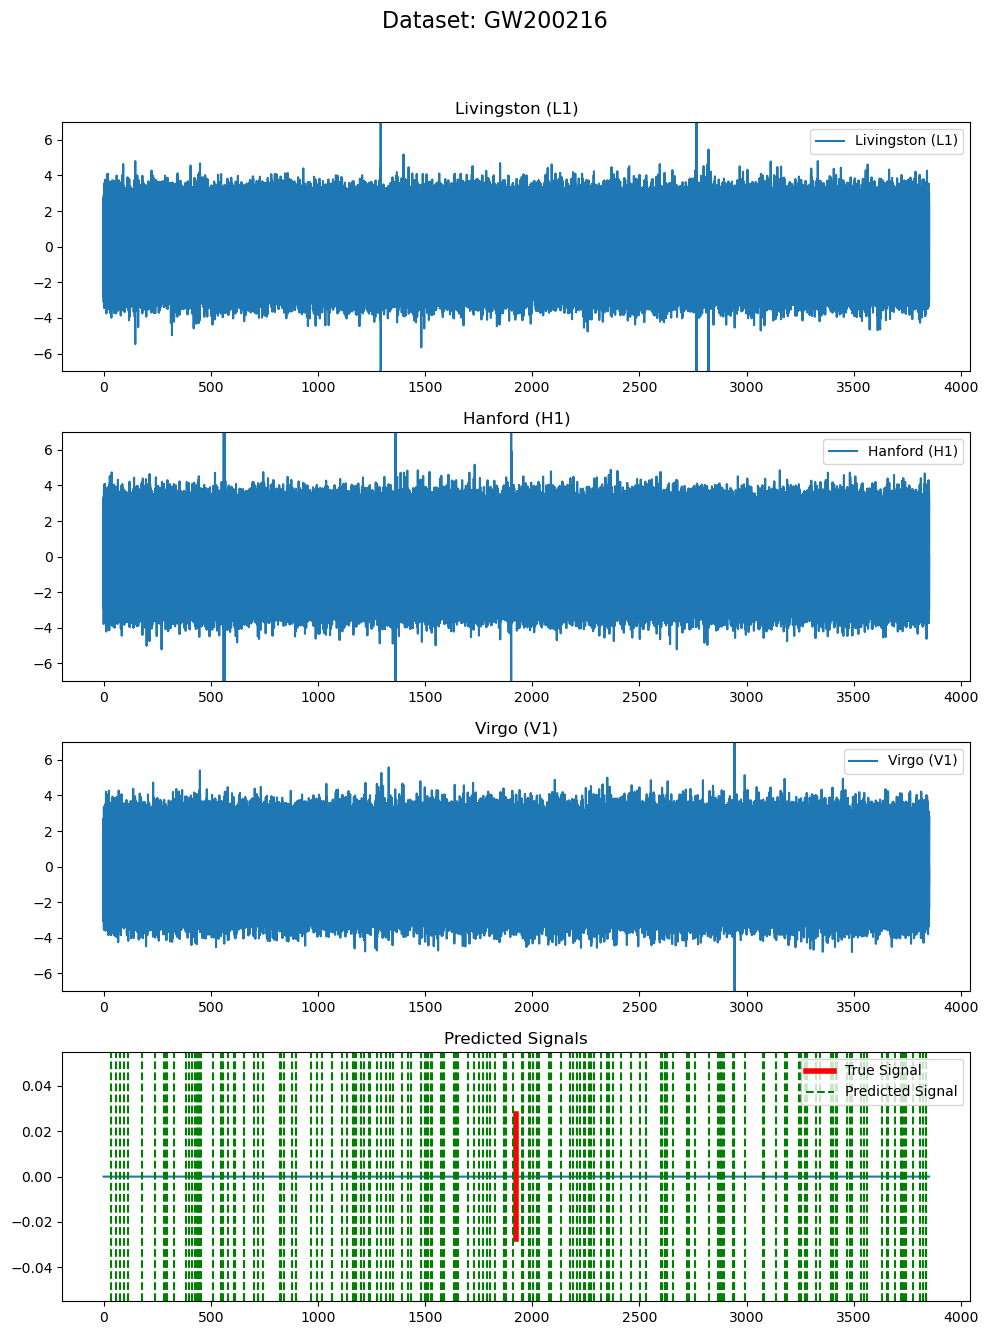

<Figure size 640x480 with 0 Axes>

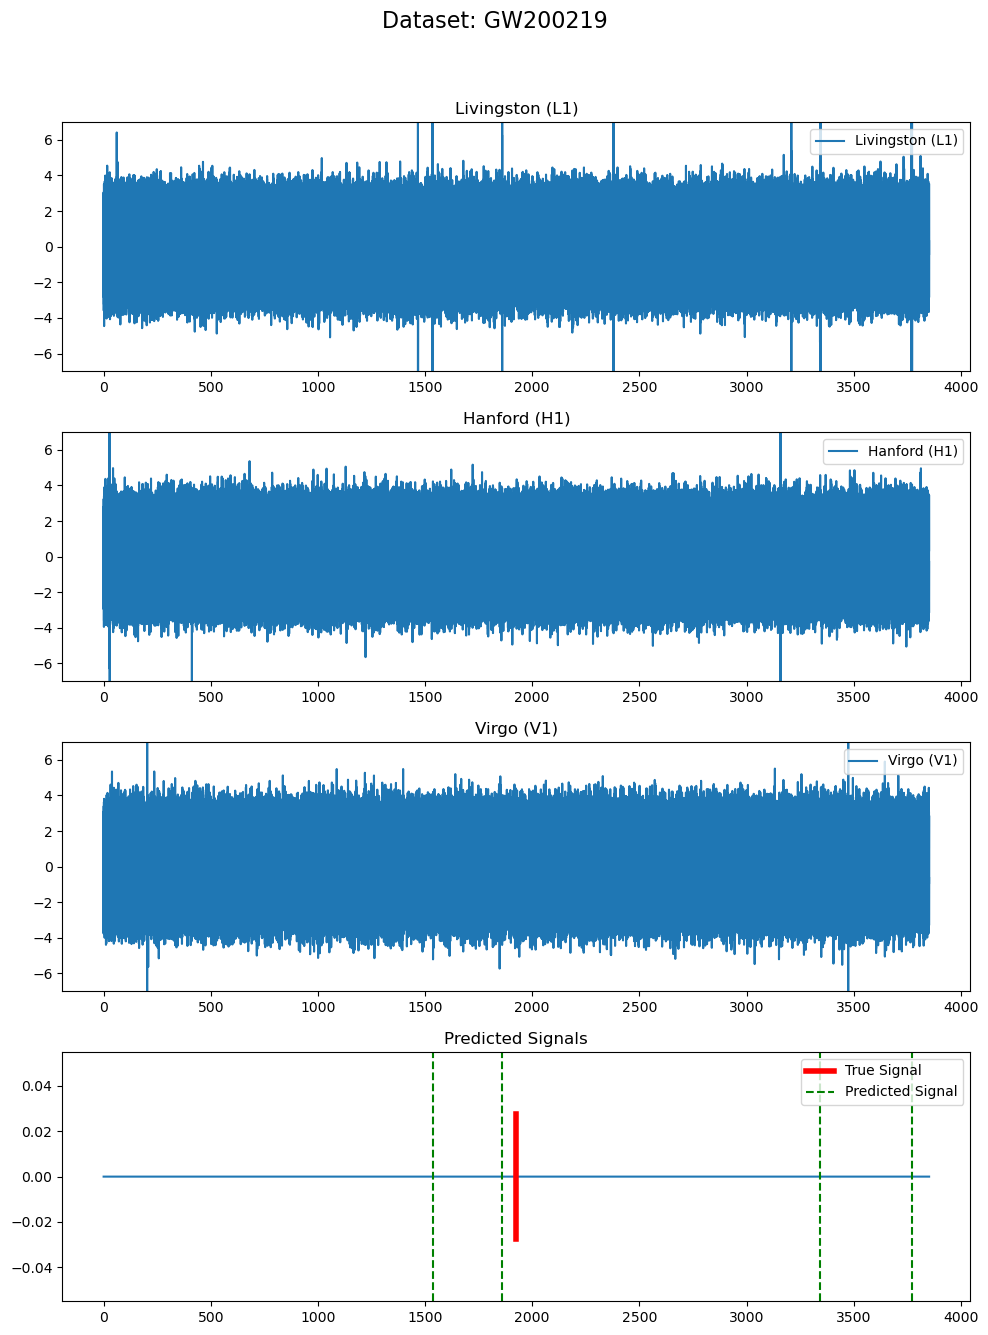

<Figure size 640x480 with 0 Axes>

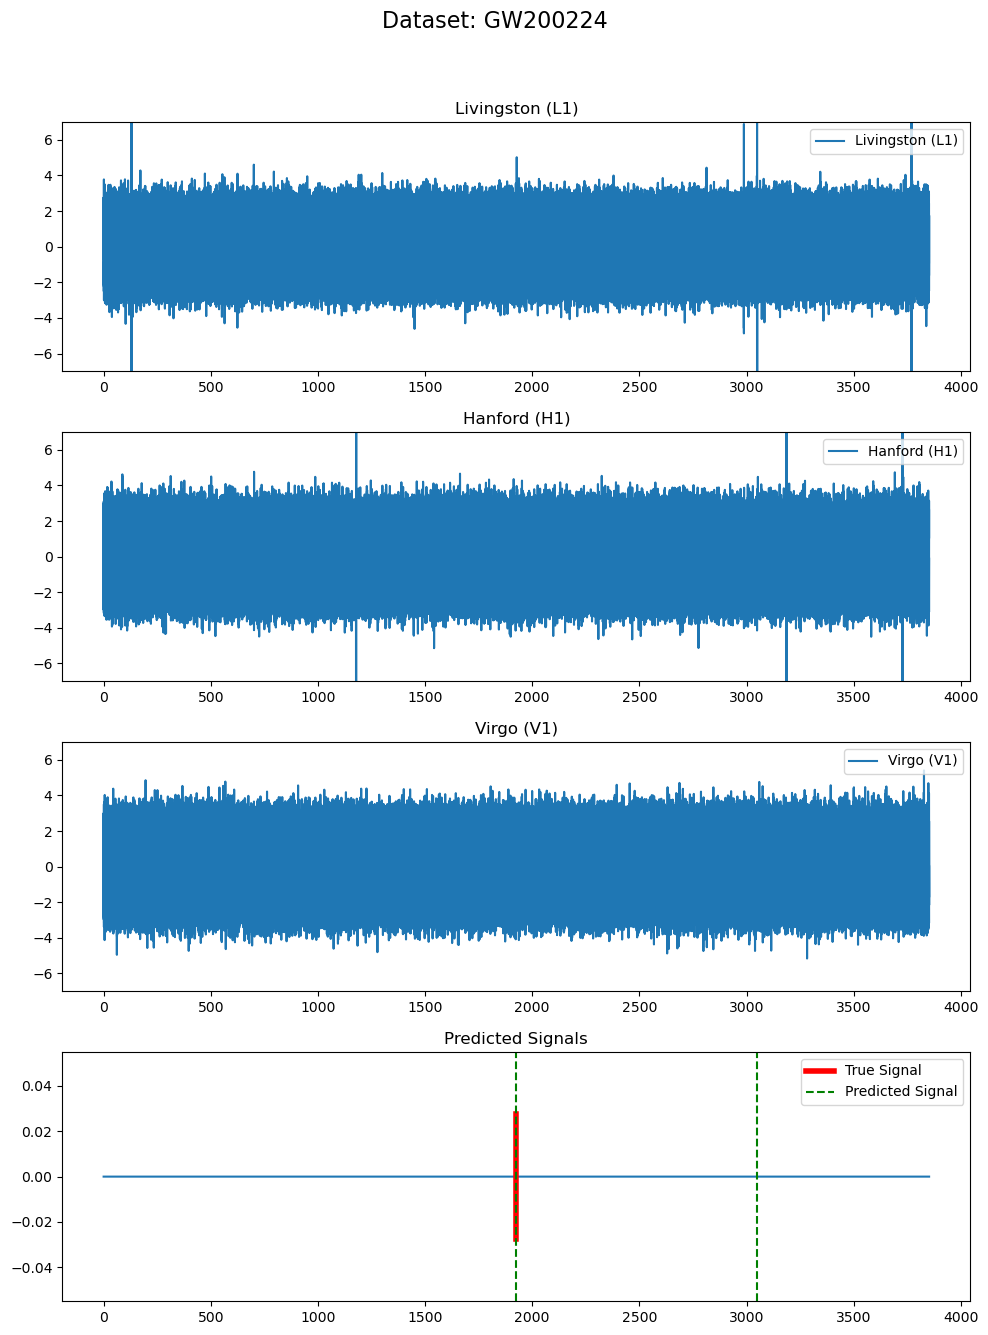

Information written to common_triggers_1.txt


In [6]:
common_triggers_info, common_triggers_count = process_triggers(dataset_name_to_dir, dataset_triggers, models, tolerance=0.05)

filename = f"common_triggers_{common_triggers_count}.txt"
with open(filename, 'w') as f:
    f.write("Model Filenames:\n")
    for model_filename in model_filenames:
        f.write(f"{model_filename}\n")
    
    f.write("\nDataset Names:\n")
    for dataset_name in dataset_name_to_dir.keys():
        f.write(f"{dataset_name}\n")
    
    f.write("\nCommon Triggers:\n")
    for dataset_name, common_triggers in common_triggers_info.items():
        f.write(f"{dataset_name}: {len(common_triggers)} triggers\n")
        f.write(f"Triggers: {common_triggers}\n")

print(f"Information written to {filename}")